# Customer Segmentation



#### Customer segmentation is the process of dividing customers into groups based on common characteristics so companies can market to each group effectively and appropriately. The process of customer segmentation is based on the premise of finding differences among the customers’ behavior and patterns.

### Need Customer Segmentation

#### Segmentation allows marketers to better tailor their marketing efforts to various audience subsets. Specifically, segmentation helps a company:

**Create and communicate targeted marketing messages that will resonate with specific customer groups.**

**Select the best communication channel for the segment.**

**Identify ways to improve products or new product or service opportunities.**

**Establish better customer relationships.**

**Test pricing options.**

**Focus on the most profitable customers.**

**Improve customer service.**

**Upsell and cross-sell other products and services.**


### Clustering:

#### The most obvious method to perform customer segmentation is using unsupervised Machine Learning methods like clustering.Clustering is a part of unsupervised learning. The purpose of clustering is to make segments in population or the data points such that in each segment each data point has significant similarity with other data points of the same segment.



### RFM Model for Customer Value:
#### Our dataset is limited to the sales records, and does not include other information about our customers. We will use a RFM,*Recency, Frequency and Monetary Value, based model of customer value for finding our customer segments. The RFM model will take the transactions of a customer and calculate three important informational attributes about each customer:

#### Recency: The value of how recently a customer purchased at the establishment
#### Frequency: How frequent the customer’s transactions are at the establishment
#### Monetary value: The dollar (or pounds in our case) value of all the transactions that the customer made at the establishment

In [1]:
#Import pandas, matplotlib.pyplot, and seaborn
import pandas as pd
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import datetime
import os
%matplotlib inline
import scipy.stats
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.api import abline_plot
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model, preprocessing
import re
from scipy import stats
from statsmodels.tsa.stattools import adfuller
import random
from datetime import datetime, timedelta
from scipy import stats
from scipy.stats import skew, norm, probplot, boxcox
from sklearn.preprocessing import StandardScaler
import math
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [2]:
myfold = os.getcwd()

In [3]:
retail_df = pd.read_csv(myfold + '/online_retail_cleaned.csv',index_col=[0])

In [4]:
retail_df.InvoiceDate = pd.to_datetime(retail_df.InvoiceDate)
retail_df.CustomerID = retail_df.CustomerID.astype('int64')
retail_df['InvoiceYearMonth'] = retail_df['InvoiceDate'].map(lambda date: 100*date.year + date.month)

In [5]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,InvoiceYearMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,201012
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,201012
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,201012
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,201012
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,201012


### Recency
#### To calculate recency, we need to decide the reference date for our analysis. we will be taking one day after the last invoice date of our data set as the reference date. Then, we will construct the recency variable as the number of days before the reference date when a customer last made a purchase.

In [6]:
ref_date = retail_df.InvoiceDate.max() + timedelta(days=1)
print('Reference Date:', ref_date)
retail_df['DaySinceLastPurchase'] = (ref_date - retail_df.InvoiceDate).dt.days
cust_hist_df =  retail_df[['CustomerID', 'DaySinceLastPurchase']].groupby("CustomerID").min().reset_index()
cust_hist_df.rename(columns={'DaySinceLastPurchase':'Recency'}, inplace=True)
cust_hist_df.head()

Reference Date: 2011-12-10 12:50:00


,CustomerID,Recency
0,12346,326
1,12347,2
2,12348,75
3,12349,19
4,12350,310


In [7]:
#Lets get a snapshot of how this recency looks like
cust_hist_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CustomerID,4338.0,15300.408022,1721.808492,12346.0,13813.25,15299.5,16778.75,18287.0
Recency,4338.0,92.536422,100.014169,1.0,18.00,51.0,142.00,374.0


We see that even though the average is 92 day recency, median is 51.

In [8]:
# Function to plot distribution and QQ-plot.
# A Q–Q plot is used to compare the shapes of distributions, providing a graphical view of how properties such as
# location, scale, and skewness are similar or different in the two distributions.
def dist_QQ_plot(data,measure):
    fig = plt.figure(figsize=(20,7))

    #Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data)

    #Kernel Density plot
    fig1 = fig.add_subplot(121)
    sns.distplot(data,fit=norm)
    fig1.set_title(measure + ' Distribution ( mu = {:.2f} and sigma = {:.2f} )'.format(mu, sigma), loc='center')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')

    #QQ plot
    fig2 = fig.add_subplot(122)
    res = probplot(data,fit=True,plot=fig2)
    fig2.set_title(measure + ' Probability Plot (skewness: {:.4f} and kurtosis: {:.4f} )'.format(data.skew(), data.kurt()), loc='center')

    plt.tight_layout()
    plt.show()



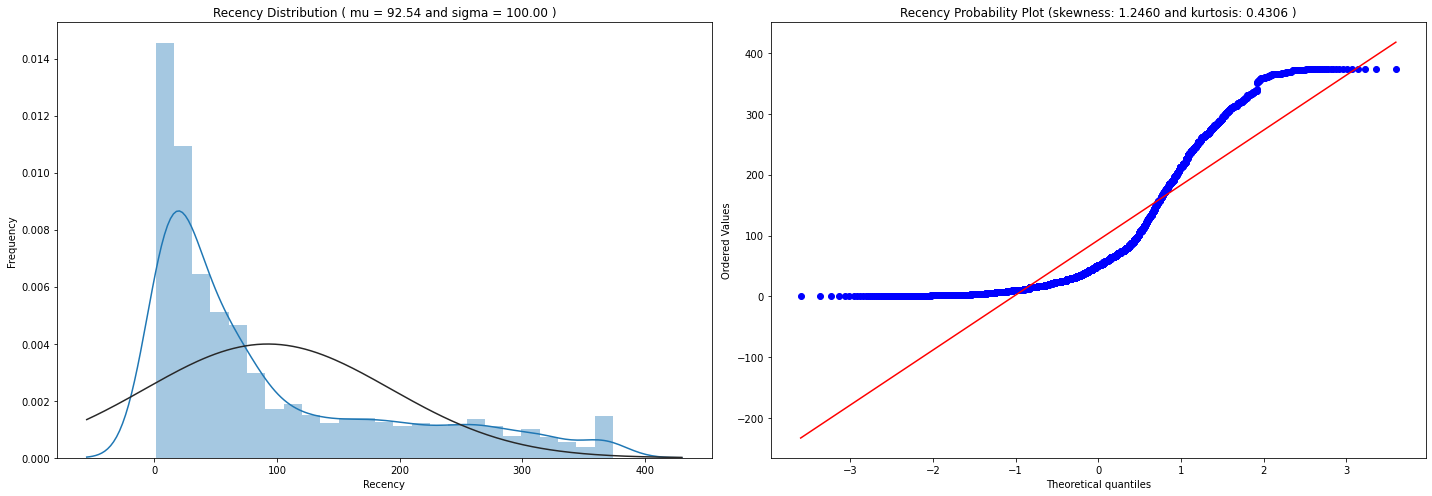

In [9]:
dist_QQ_plot(cust_hist_df.Recency,'Recency')

The recency distribution graph above shows that the sales recency distribution is skewed, has a peak on the left and a long tail to the right. It deviates from normal distribution and is positively biased.

Probability Plot, shows that the sales recency also does not align with the diagonal red line that represents the normal distribution. The form of its distribution confirms that it is right skewed.

### Frequency
#### To create frequency clusters, we need to find total number orders for each customer.

In [10]:
cust_frequency = (retail_df[['CustomerID','InvoiceNo']].groupby(['CustomerID','InvoiceNo']).count().reset_index())\
                    .groupby('CustomerID').count().reset_index()
cust_frequency.rename(columns={'InvoiceNo':'Frequency'},inplace=True)
cust_hist_df = pd.merge(cust_hist_df,cust_frequency,on='CustomerID')
cust_hist_df.head()

,CustomerID,Recency,Frequency
0,12346,326,1
1,12347,2,7
2,12348,75,4
3,12349,19,1
4,12350,310,1


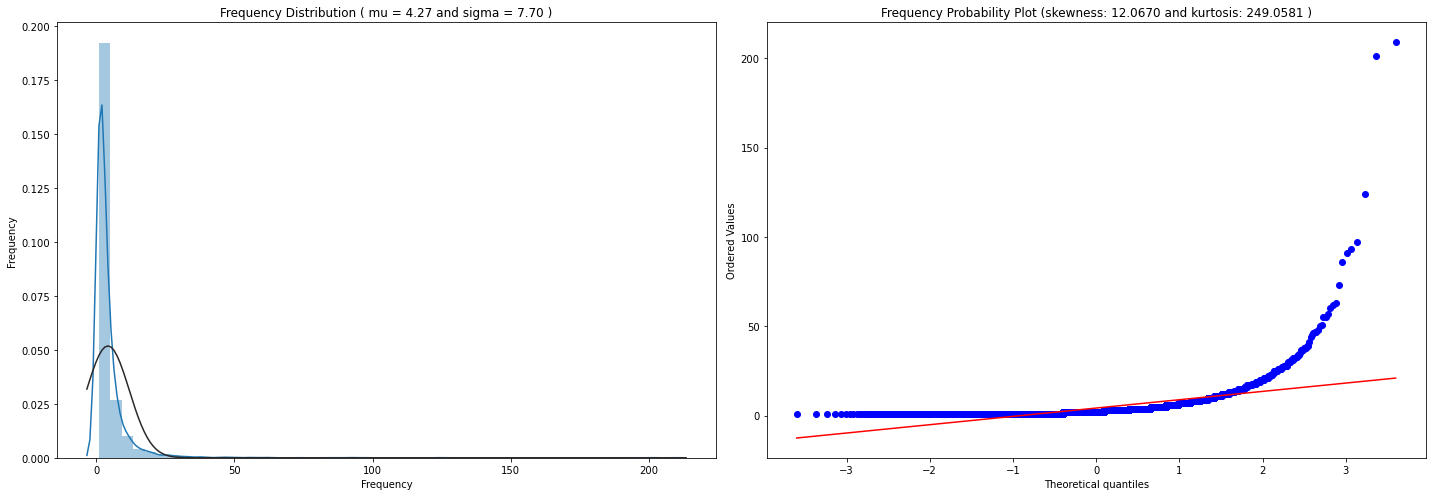

In [11]:
dist_QQ_plot(cust_hist_df.Frequency,'Frequency')

From the graph it is clear that the sales frequency distribution is skewed,has a peak on the left and a long tail to the right. It deviates from normal distribution and is positively biased.

Probability Plot, shows that the sales frequency also does not align with the diagonal red line that represents the normal distribution. The form of its distribution confirms that it is right skewed.

### Monetary Value
####  We will calculate revenue for each customer, plot a histogram and QQ plot

In [12]:
cust_value = retail_df[['CustomerID','Amount']].groupby('CustomerID').sum().reset_index()
cust_hist_df = pd.merge(cust_hist_df,cust_value,on='CustomerID')


In [13]:
cust_hist_df.head()

,CustomerID,Recency,Frequency,Amount
0,12346,326,1,77183.60
1,12347,2,7,4310.00
2,12348,75,4,1797.24
3,12349,19,1,1757.55
4,12350,310,1,334.40


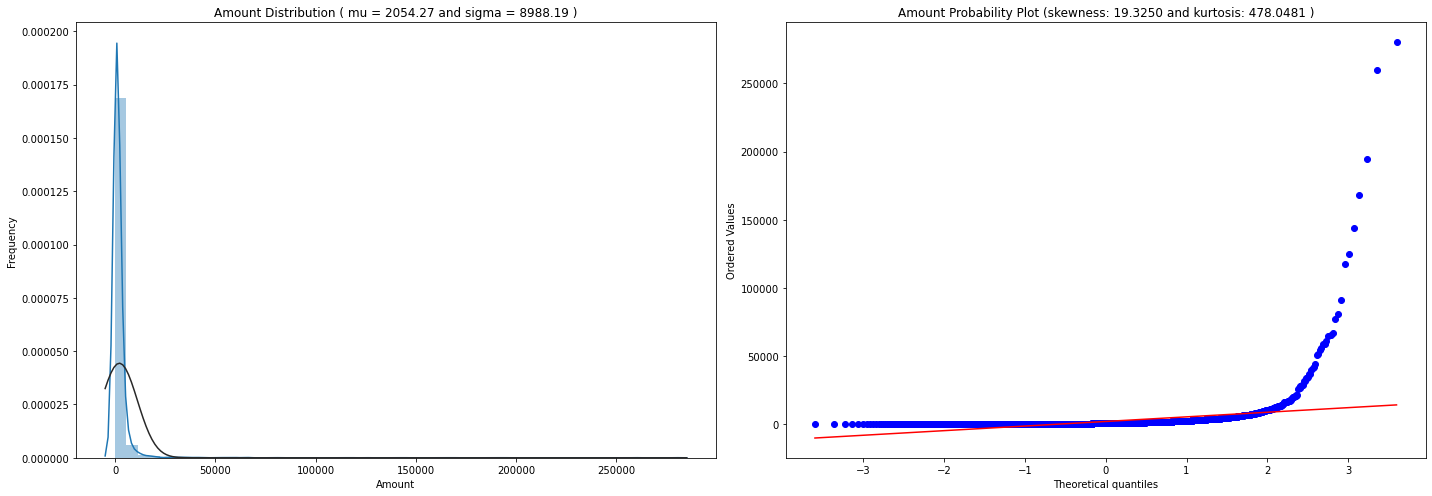

In [14]:
dist_QQ_plot(cust_hist_df.Amount,'Amount')

The revenue distribution graph above shows that the distribution is skewed, has a peak on the left and a long tail to the right. It deviates from normal distribution and is positively biased.

Probability Plot, shows that the sales revenue also does not align with the diagonal red line that represents the normal distribution. The form of its distribution confirms that it is right skewed.

In [15]:
cust_hist_df.describe()

,CustomerID,Recency,Frequency,Amount
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,15300.408022,92.536422,4.272015,2054.266460
std,1721.808492,100.014169,7.697998,8989.230441
min,12346.000000,1.000000,1.000000,3.750000
25%,13813.250000,18.000000,1.000000,307.415000
50%,15299.500000,51.000000,2.000000,674.485000
75%,16778.750000,142.000000,5.000000,1661.740000
max,18287.000000,374.000000,209.000000,280206.020000


### Data Preprocessing

We have now created our customer value dataset.
Lets perform some preprocessing on the data.

For the customer segmentation,we will be using the K-means clustering algorithm. One of the requirements for proper functioning of the algorithm is the centering of the variable with different means. Mean centering refers to replacing the actual value of the variable with a standardized value, so that the variable has a mean of 0 and variance of 1. This ensures that all the variables are in the same range and the difference in ranges of values does not degrade the performance of the algorithm. This is similar to feature scaling.

Another problem is the huge range of values each variable takes as seen from the monetary amount variable. To address this problem, we will transform all the variables on the log scale. This transformation, along with the standardization, will ensure that the input to our algorithm is a homogenous set of scaled and transformed values.

Sequece of steps
1. Unskew the data - log transformation
2. Standardize to the same average values and scale to the same standard deviation

An important point about the data preprocessing step is that sometimes we need it to be reversible. In our case, we will have the clustering results in terms of the log transformed and scaled variable. But to make inferences in terms of the original data, we will need to reverse transform all the variable so that we get back the actual RFM figures. This can be done by using the preprocessing capabilities of Python.

In [16]:
cust_hist_df=cust_hist_df.set_index('CustomerID')
X_subset = np.log(cust_hist_df)
X_subset

,Recency,Frequency,Amount
CustomerID,,,
12346,5.786897,0.000000,11.253942
12347,0.693147,1.945910,8.368693
12348,4.317488,1.386294,7.494007
12349,2.944439,0.000000,7.471676
12350,5.736572,0.000000,5.812338
...,...,...,...
18280,5.627621,0.000000,5.196285
18281,5.198497,0.000000,4.392224
18282,2.079442,0.693147,5.182064


In [17]:
X_subset.rename(columns={'Recency':'Recency_log','Frequency':'Frequency_log','Amount':'Amount_log'}, inplace=True)

In [18]:
#cust_hist_df['Recency_log'] = cust_hist_df['Recency'].apply(math.log)
#cust_hist_df['Frequency_log'] = cust_hist_df['Frequency'].apply(math.log)
#cust_hist_df['Amount_log'] = cust_hist_df['Amount'].apply(math.log)
#feature_vector = ['Recency_log','Frequency_log','Amount_log']

In [19]:
#X_subset = cust_hist_df[feature_vector]
scaler = StandardScaler().fit(X_subset)
X_scaled = scaler.transform(X_subset)
pd.DataFrame(X_scaled,columns=X_subset.columns).describe().T

,count,mean,std,min,25%,50%,75%,max
Recency_log,4338.0,-1.027980e-16,1.000115,-2.630445,-0.612424,0.114707,0.829652,1.505796
Frequency_log,4338.0,-2.355833e-16,1.000115,-1.048610,-1.048610,-0.279044,0.738267,4.882714
Amount_log,4338.0,-1.013738e-16,1.000115,-4.179280,-0.684183,-0.060942,0.654244,4.721395


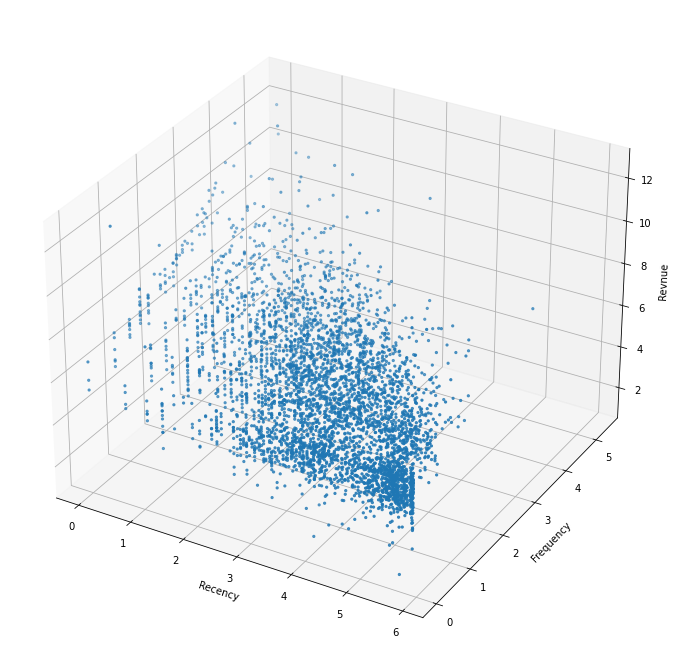

In [20]:
fig = plt.figure(figsize=(16,12))
xs = X_subset.Recency_log
ys = X_subset.Frequency_log
zs = X_subset.Amount_log
ax = fig.add_subplot(111, projection = '3d')

ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Revnue")

ax.scatter(xs, ys, zs,s=5)
plt.show()

It is clear that the repeat customers who buy frequently results in higher revenue.

In [21]:
data_normalized = pd.DataFrame(data=X_scaled, index=cust_hist_df.index, columns=cust_hist_df.columns)


### Clustering for Segments - K Means Clustering

The K-means clustering belongs to the partition\centroid based hard clustering family of algorithms.

We can describe the k-means algorithm as a simple optimization problem, an iterative approach for minimizing the within-cluster sum of squared errors (SSE), which is sometimes also called cluster inertia. The objective of K-Means clustering is to minimize total intra-cluster variance, or, the squared error function.

It has 4 basic steps:
1. The algorithm starts with random point initializations of the required number of centers. The “K” in K-means stands for the number of clusters.
2. In the next step, each of the data point is assigned to the center closest to it. The distance metric used in K-means clustering is normal Euclidian distance.
3. Once the data points are assigned, the centers are recalculated by averaging the dimensions of the points belonging to the cluster.
4. The process is repeated with new centers until we reach a point where the assignments become stable. In this case, the algorithm terminates.


K-means++
The initial centroids are placed far away from each other via the k-means++ algorithm, which leads to better and more consistent results than the classic k-means.

In [22]:
from sklearn.cluster import KMeans
cl=10

# A list to hold the SSE values for each k
ss = []
krange = range(1, cl+1)
for k in krange:
    model = KMeans(n_clusters=k,init = 'k-means++', random_state = 42)
    model.fit_predict(X_scaled)
    ss.append(model.inertia_)
# These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
    labels = model.labels_


### Identifying the optimal number of clusters

One of the most perplexing issues we face while trying to segment customers or products is choosing the ideal number of segments. 
This is a key parameter for multiple clustering algorithms like K means.
For our analysis we will use the following techniques to indentify the optimal number of clusters.

1. Elbow method
2. Gap Statistic
3. Silhouette Coefficient


####  Elbow Metod

It is the most popular method for determining the optimal number of clusters. The method is based on calculating the Within-Cluster-Sum of Squared Errors (WSS) for different number of clusters (k) and selecting the k for which change in WSS first starts to diminish.
The idea behind the elbow method is that the explained variation changes rapidly for a small number of clusters and then it slows down leading to an elbow formation in the curve. The elbow point is the number of clusters we can use for our clustering algorithm.

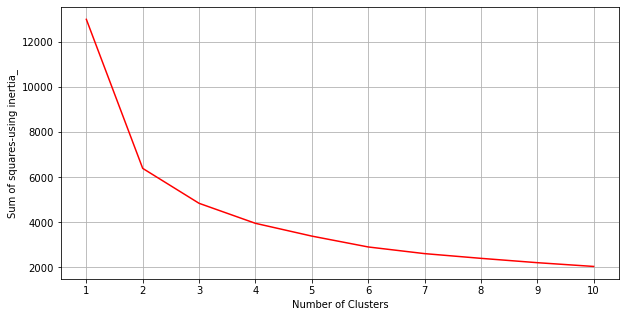

In [23]:
# plot showing 𝑆𝑆 for each 𝐾.
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,5))
plt.plot(krange, ss,c='red')
plt.xticks(krange)
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of squares-using inertia_")
plt.grid()
plt.show()

Elbow Method by calculating sum-of-squares error in each cluster against 𝐾 confirms that the best will be k=4 (plot starts descending much more slowly after k=4)

In [24]:
k_best_elbow=4

####  Gap Statistic Method

The idea behind their approach was to find a way to compare cluster compactness with a null reference distribution of the data, i.e. a distribution with no obvious clustering. Their estimate for the optimal number of clusters is the value for which cluster compactness on the original data falls the farthest below this reference curve. 

Calculating gap statistic for k means clustering involves the following steps:
1. Cluster the observed data on various number of clusters and compute compactness of our clustering
2. Generate reference data sets and cluster each of them with varying number of clusters. The reference datasets are created from a “continuous uniform” distribution using the random_sample function.
3. Calculate average of compactness of our clustering on reference datasets
4. Calculate gap statistics as difference in compactness between clustering on reference data and original data

In [25]:
def optimalK(data, nrefs=3, maxClusters=15):
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    
    for gap_index, k in enumerate(range(1, maxClusters)):

        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)
        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(n_clusters=k,init = 'k-means++', random_state = 42)
            km.fit_predict(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Fit cluster to original data and create dispersion
        km = KMeans(n_clusters=k,init = 'k-means++', random_state = 42)
        km.fit_predict(data)
        
        origDisp = km.inertia_

        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)

    return (gaps.argmax() + 1, resultsdf)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal
    


In [26]:
k, gapdf = optimalK(X_scaled, nrefs=5, maxClusters=cl+1)
print ('Optimal k is: ', k)
k_best_gap_stat=k

Optimal k is:  3


The results of the calculated gaps is shown below.The higher the value, the more optimal it is.

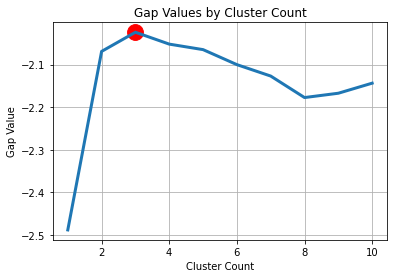

In [27]:
plt.plot(gapdf.clusterCount, gapdf.gap, linewidth=3)
plt.scatter(gapdf[gapdf.clusterCount == k].clusterCount, gapdf[gapdf.clusterCount == k].gap, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()


In [28]:
k_best_gap =3

#### Silhouette analysis on K-Means clustering

Silhouette analysis can be used to study the separation distance between the resulting clusters, as a strategy to quantifying the quality of clustering via graphical tool to plot a measure of how tightly grouped the samples in the clusters are. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually.

It can also be applied to clustering algorithms other than k-means

Silhouette coefficients has a range of [-1, 1], it calculated by:

Calculate the cluster cohesion a( i )as the average distance between a sample x( i ) and all other points in the same cluster.
Calculate the cluster separation b( i ) from the next closest cluster as the average distance between the sample 
x( i ) and all samples in the nearest cluster.
Calculate the silhouette s( i ) as the difference between cluster cohesion and separation divided by the greater of the two, as shown here:imageWhich can be also written as:image
Where:

If near +1, it indicate that the sample is far away from the neighboring clusters.
a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.
If most objects have a high value, then the clustering configuration is appropriate.
If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.
A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters
Negative values indicate that those samples might have been assigned to the wrong cluster.
The silhouette plot can shows a bad K clusters pick for the given data due to the presence of clusters with below average silhouette scores and also due to wide fluctuations in the size of the silhouette plots. A good k clusters can found when all the plots are more or less of similar thickness and hence are of similar sizes.

Although we have to keep in mind that in several cases and scenarios, sometimes we may have to drop the mathematical explanation given by the algorithm and look at the business relevance of the results obtained.

Let's see below how our data perform for each K clusters groups (between 3 and 7) in the silhouette score of each cluster, along with the center of each of the cluster discovered in the scatter plots, by amount_log vs recency_log and vs frequency_log.

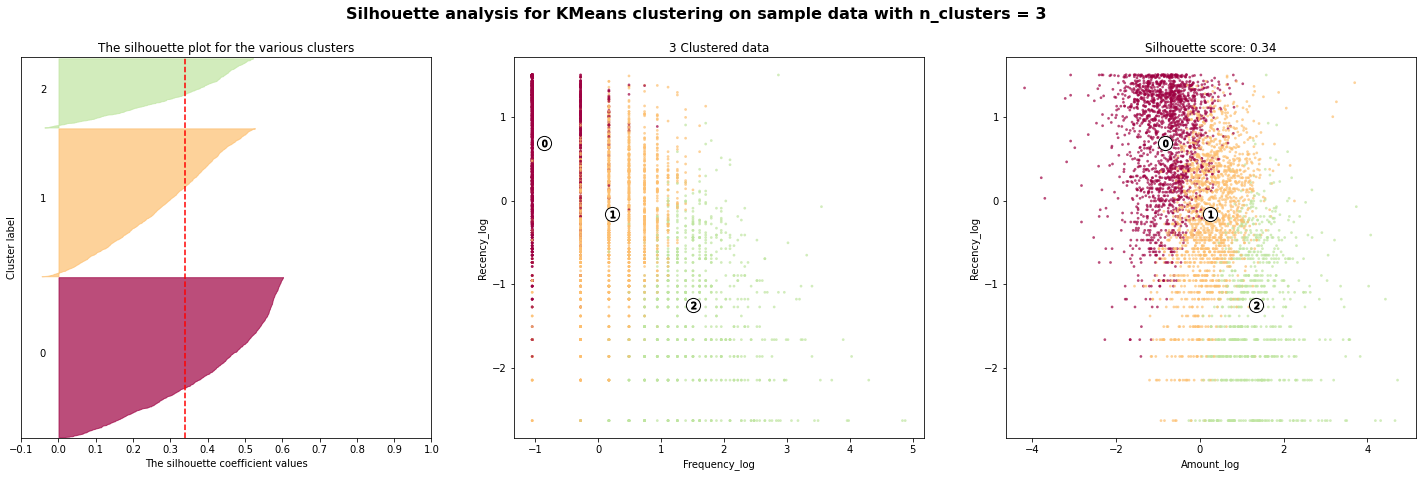

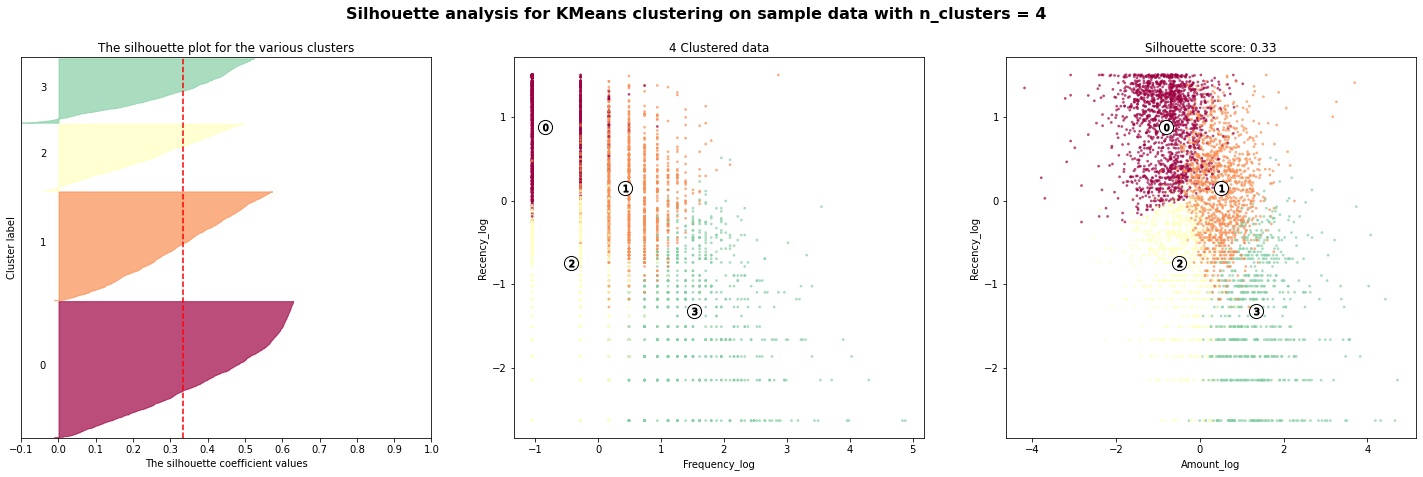

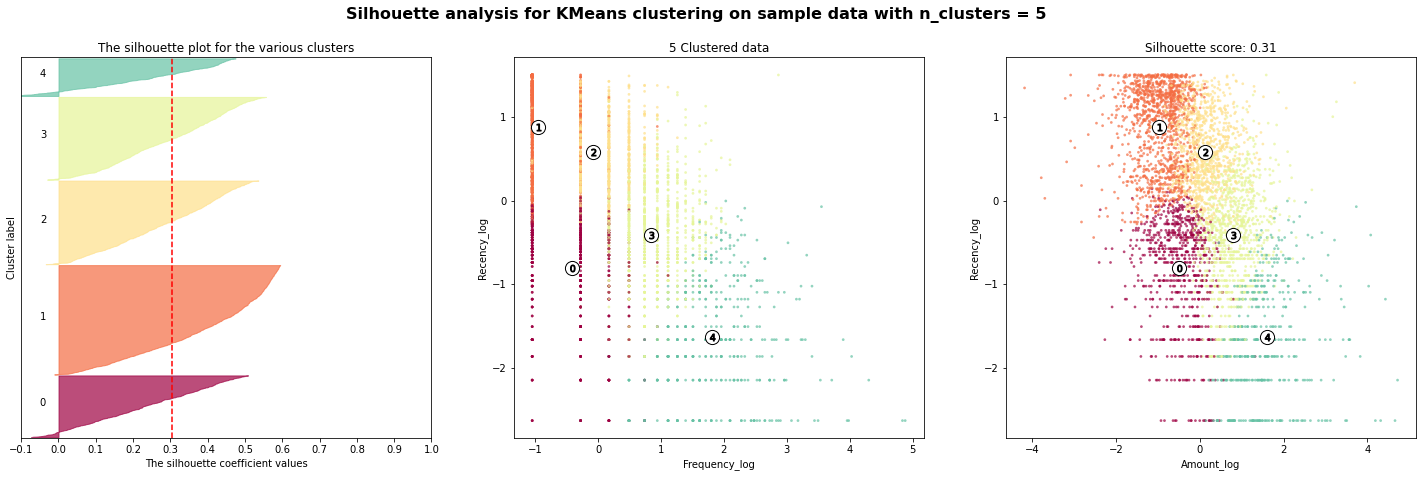

In [29]:
import matplotlib.cm as cm
feature_vector = ['Recency_log','Frequency_log','Amount_log']
cluster_centers = dict()

for n_clusters in range(3,6,1):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_size_inches(25, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_scaled) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10,max_iter=300, tol=1e-04, random_state=42)
    cluster_labels = clusterer.fit_predict(X_scaled)

    silhouette_avg = silhouette_score(X = X_scaled, labels = cluster_labels)
    cluster_centers.update({n_clusters :{'cluster_center':clusterer.cluster_centers_,
                                         'silhouette_score':silhouette_avg,
                                         'labels':cluster_labels}
                           })

    sample_silhouette_values = silhouette_samples(X = X_scaled, labels = cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.Spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
    colors = cm.Spectral(cluster_labels.astype(float) / n_clusters)
    
    centers = clusterer.cluster_centers_
    y = 0
    x = 1
    ax2.scatter(X_scaled[:, x], X_scaled[:, y], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')   
    ax2.scatter(centers[:, x], centers[:, y], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[x], c[y], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    ax2.set_title("{} Clustered data".format(n_clusters))
    ax2.set_xlabel(feature_vector[x])
    ax2.set_ylabel(feature_vector[y])

    x = 2
    ax3.scatter(X_scaled[:, x], X_scaled[:, y], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')   
    ax3.scatter(centers[:, x], centers[:, y], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax3.scatter(c[x], c[y], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    ax3.set_title("Silhouette score: {:1.2f}".format(cluster_centers[n_clusters]['silhouette_score']))
    ax3.set_xlabel(feature_vector[x])
    ax3.set_ylabel(feature_vector[y])
    
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data with n_clusters = %d" % n_clusters),
                 fontsize=16, fontweight='bold')
    plt.show()

When we look at the results of the clustering process, we can infer some interesting insights:

All the K clusters options are valid, because there is no presence of clusters with below average silhouette scores.
All options had wide fluctuations in the size of the silhouette plots.
So, our best choice lies on the option that gives us a simpler business explanation and at the same time target customers in focus groups with sizes closer to the desired.


### Profile and interpret segments

#### Approaches to build customer personas

* Summary statistics for each cluster centers e.g. RFM values
* Relative importance of cluster attributes compared to population
* Snake plots to understand and compare segments

#### Summary statistics for each cluster centers:
Let's look at the cluster center values after returning them to normal values from the log and scaled version.

In [30]:
features = ['Recency',  'Frequency',  'Amount']
for i in range(3,6,1):
    print("for {} clusters the silhouette score is {:1.2f}".format(i, cluster_centers[i]['silhouette_score']))
    print("Centers of each cluster:")
    cent_transformed = scaler.inverse_transform(cluster_centers[i]['cluster_center'])
    print(pd.DataFrame(np.exp(cent_transformed),columns=features))
    print('-'*50)

for 3 clusters the silhouette score is 0.34
Centers of each cluster:
      Recency  Frequency       Amount
0  115.938985   1.185917   260.171159
1   34.517136   3.144894  1005.824234
2    7.230229   9.964304  3924.968748
--------------------------------------------------
for 4 clusters the silhouette score is 0.33
Centers of each cluster:
      Recency  Frequency       Amount
0  153.398108   1.196931   267.202714
1   53.293280   3.772475  1365.818337
2   14.780012   1.750981   395.540264
3    6.502773  10.174447  4000.482026
--------------------------------------------------
for 5 clusters the silhouette score is 0.31
Centers of each cluster:
      Recency  Frequency       Amount
0   13.531089   1.759663   394.447109
1  152.731471   1.085433   213.482985
2   99.524516   2.372810   852.459464
3   24.050122   5.514949  1997.411280
4    4.206772  13.226861  5460.153603
--------------------------------------------------


Clusters Insights:
With the plots and the center in the correct units, let's see some insights by each clusters groups:

Analysis:three-cluster

1. The tree clusters appears have a good differences in the Monetary value of the customer.
2. Cluster 2 is the cluster of high value customers who shop frequently and is the important segment for any business.
3. In the similar way we obtain customer groups with low and medium spends in clusters with labels 2 and 0 respectively.
4. Frequency and Recency correlate perfectly to the Monetary value based on the trend (High Monetary-Low Recency-High Frequency).

Analysis:four-cluster

1. Clusters 0 and 2 look very similar, but when look deeper we can see that cluster 2 are more recent purchasers and have a slightly higher frequncy of buying and monetray value.
2. Cluster 2 customersmake low-cost purchases, with a relatively low frequency, but above cluster 0 customers, and made their last purchase more recently. This group of customers probably response to price discounts and can be subject to loyalty promotions to try increase the medium-ticket, strategy that can be better defined when we analyzing the market basket.
3. The cluster 1 purchases medium amounts, with a relatively low frequency and not very recent
Cluster 3 is the cluster of high value customer who shops frequently and is certainly an important segment for each business.
4. The silhouette score matrix says that the 4 cluster segments are less optimal then the three cluster segments.


Analysis:five-cluster

1. Note that clusters 0 and 1 are very similar.
2. The cluster 0 makes low-cost purchases, with a relatively low frequency, but above 0, and made their last purchase more recently
3. The cluster 4 appears more robust on the affirmation of those who shop often and with high amount.
4. The cluster 2 are those who have a decent spend but are not that frequent.
5. The cluster 3 purchases medium amounts, with a relatively medium frequency and are more recent in purchases than cluster 2.
6. Cluster 0 and and cluster 3 group of customers may probably respond to price discounts and can be subject to loyalty promotions to try increase the medium-ticket, strategy that can be better defined when analyzing the market basket.
7. The silhouette score matrix says that the five cluster segments is less optimal then the three cluster segments.

k_best_silhouette = 3

####  Snake plot

In [31]:
data_normalized['cluster'] = cluster_centers[3]['labels'] 
# Melt the normalized dataset and reset the index
cust_hist_melt = pd.melt(data_normalized.reset_index(), 
                        
# Assign CustomerID and Cluster as ID variables
                    id_vars=['CustomerID', 'cluster'],

# Assign RFM values as value variables
                    value_vars=['Recency', 'Frequency', 'Amount'], 
                        
# Name the variable and value
                    var_name='Metric', value_name='Value')

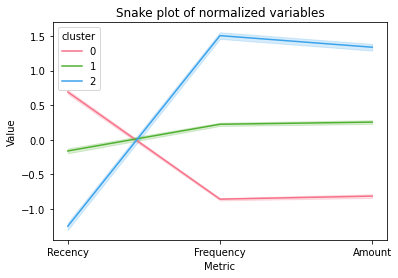

In [32]:
# Visualize snake plot
palette = sns.color_palette("husl", 3)

# Add the plot title
plt.title('Snake plot of normalized variables')

# Add the x axis label
plt.xlabel('Metric')

# Add the y axis label
plt.ylabel('Value')

# Plot a line for each value of the cluster variable
sns.lineplot(data=cust_hist_melt, x='Metric', y='Value', hue='cluster',palette=palette)
plt.show()

#### Calculate relative importance of each attribute

In [33]:
cust_hist_df_c3= cust_hist_df.copy(deep=True)
cust_hist_df_c3['cluster'] = cluster_centers[3]['labels'] 

In [34]:
# Calculate average RFM values for each cluster
cluster_avg = cust_hist_df_c3.groupby(['cluster']).mean() 

# Calculate average RFM values for the total customer population
population_avg = cust_hist_df.mean()

# Calculate relative importance of cluster's attribute value compared to population
relative_imp = cluster_avg / population_avg - 1

# Print relative importance scores rounded to 2 decimals
print(relative_imp.round(2))

         Recency  Frequency  Amount
cluster                            
0           0.75      -0.70   -0.84
1          -0.41      -0.18   -0.34
2          -0.86       2.02    2.66


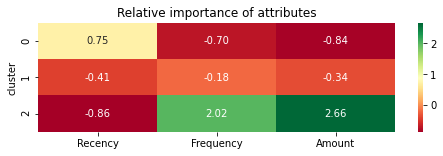

In [35]:
# Relative importance heatmap
# Initialize a plot with a figure size of 8 by 2 inches 
plt.figure(figsize=(8, 2))

# Add the plot title
plt.title('Relative importance of attributes')

# Plot the heatmap
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()

In [36]:
cust_hist_df_c3.head()

,Recency,Frequency,Amount,cluster
CustomerID,,,,
12346,326,1,77183.60,1
12347,2,7,4310.00,2
12348,75,4,1797.24,1
12349,19,1,1757.55,1
12350,310,1,334.40,0


Text(0.5, 1.0, '3 Clusters')

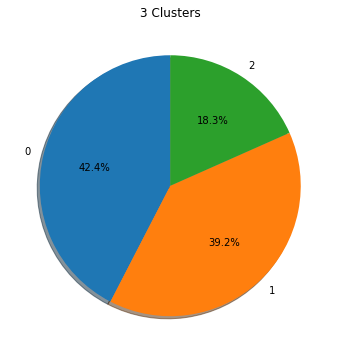

In [37]:
fig = plt.figure(figsize=(8,6))
market = cust_hist_df_c3.cluster.value_counts()
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('3 Clusters')

# Collaboration Filtering

Recommendation systems are used all around us. These systems  personalize our web experience, telling us what to buy (Amazon), which movies to watch (Netflix), whom to be friends with (Facebook), which songs to listen (Spotify) etc. These recommendation systems leverage our shopping/ watching/ listening patterns and predict what we could like in future based on our behavior patterns.The most basic models for recommendations systems are collaborative filtering models which are based on assumption that people like things similar to other things they like, and things that are liked by other people with similar taste.

There are a lot of library options for Python when it comes to recommendation systems: SciPy, Annoy (a system that Spotify uses), LightFM, tensorrec, NMSLib, Implicit, Spotlight, Faiss, etc. I have opted for Surprise because it is pretty quick to get it up and running.

Surprise has a variety of algorithms to go with, including SVD, Non-Negative Matrix Factorization and more, but the k-NNs are the only ones that support item-item.


In [38]:
from surprise import NormalPredictor
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise import KNNBasic, KNNWithMeans, KNNBaseline, KNNWithZScore
from surprise import get_dataset_dir, dump
from surprise.model_selection import GridSearchCV
import random

The transaction dataset we are using does not have any ratings and we will build one based on the number of times an item was ordered by a user.

In [39]:
# The score will be based on how many times a customer has purchased an item converted to 1-5 scale

recData = retail_df.groupby(['CustomerID','StockCode'], as_index = False).agg({'InvoiceNo': 'nunique'})
recData.rename(columns = {'CustomerID':'userID','StockCode':'itemID','InvoiceNo':'rating'}, inplace = True)

In [40]:
recData['rating'] = recData['rating'].apply(lambda x: round((x-1)*(4/84)+1),0)

### Surprise package:
#### This package has been specially developed to make recommendation based on collaborative filtering easy. It has default implementation for a variety of CF algorithms.
The data frame must have three columns, corresponding to the user ids, the item ids, and the ratings in this order. Each row thus corresponds to a given rating.

In [41]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))
# Load the data from the file using the reader format

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(recData[['userID', 'itemID', 'rating']], reader)


In [42]:
my_seed = 0
random.seed(my_seed)
np.random.seed(my_seed)

We will benchmark the following algorithms:
* KNNWithZScore - KNNWithZScore is a basic collaborative filtering algorithm, taking into account the z-score normalization of each user.
* KNNWithMeans - KNNWithMeans is basic collaborative filtering algorithm, taking into account the mean ratings of each user.
* KNNBaseline - KNNBaseline is a basic collaborative filtering algorithm taking into account a baseline rating.
* KNNBasic - KNNBasic is a basic collaborative filtering algorithm.

We will use “rmse” as our accuracy metric for the predictions.

In [43]:

benchmark = []
# Iterate over all algorithms
for algorithm in [KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')   

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


,test_rmse,fit_time,test_time
Algorithm,,,
KNNWithZScore,0.050390,1.398475,9.845941
KNNWithMeans,0.051560,1.260634,9.047126
KNNBaseline,0.051933,1.495407,11.370895
KNNBasic,0.054231,1.385951,8.807874


KNNWithZScore algorithm gave us the best rmse.

### Tuning the Algorithm Parameters

Surprise provides a GridSearchCV class analogous to GridSearchCV from scikit-learn.

With a dict of all parameters, GridSearchCV tries all the combinations of parameters and reports the best parameters for any accuracy measure

We can check which similarity metric works best with our choosen model:

In [44]:
sim_options = {
    "name": ["msd", "cosine","pearson_baseline"],
    "min_support": [3, 4, 5],
    "user_based": [False],
}

param_grid = {"sim_options": sim_options}

gs = GridSearchCV(KNNWithZScore, param_grid, measures=["rmse"], cv=3)
gs.fit(data)

print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix.

In [45]:
Best_sim_Option = gs.best_params.get('rmse',{}).get('sim_options',{})

In [46]:
# Now build a full Surprise training set from the dataset
trainset = data.build_full_trainset()
similarity_matrix = KNNWithZScore(sim_options= Best_sim_Option).fit(trainset).compute_similarities()

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [47]:
# Let's pick a user ID and see how the final recommendations change
test_subject = 12680
# Get the top k items the user rated
k=20

In [48]:
# When using Surprise there are RAW IDs and INNER IDs
# RAW IDs are the IDs from our train dataset
# The RAW ID is converted to an unique integer that Surprise can easily manipulate for computations.
# In order find a user inside the trainset, we need to convert their RAW ID to INNER ID.
# For more details on this read:https://surprise.readthedocs.io/en/stable/FAQ.html#what-are-raw-and-inner-ids

test_subject_iid = trainset.to_inner_uid(test_subject)

In [49]:
import heapq
#get the top k items we rated
test_subject_ratings = trainset.ur[test_subject_iid]
k_neighbors = heapq.nlargest(k,test_subject_ratings,key =lambda t:t[1])



In [50]:
from collections import defaultdict

#Default dict is a standard dicrionary
#It does not throw an error when trying to access a key that does not exist, 
#Instead a new entry with the key is created.
candidates = defaultdict(float)

for itemID, rating in k_neighbors:
    try:

        similarities = similarity_matrix[itemID]
        for innerID,score in enumerate(similarities):
            candidates[innerID] += score * (rating / 5.0)
    except:
        continue

In [51]:
# utility to get the item description
def getItemName(itemID):
    try:
        item = retail_df[retail_df['StockCode']== itemID].iloc[0]
        desc = item.Description
    except:
        desc=''
    return desc 

In [52]:
# Build a dictionary of items that the user has ordered
ordered ={}
for itemID,rating in trainset.ur[test_subject_iid]:
    ordered[itemID] = 1


In [53]:
from operator import itemgetter

# Add items to users list of recomendations
# if they are similar to the items ordered
# but have not been ordered by the user
recommendations= []

position = 0
for itemID,rating_sum in sorted(candidates.items(),key = itemgetter(1),reverse=True):
    if not itemID in ordered:
        recommendations.append(getItemName(trainset.to_raw_iid(itemID)))
        position += 1
        if position > 10:break
            
for rec in recommendations:
    print('Item :', rec)


Item : BATHROOM METAL SIGN 
Item : PLAYING CARDS KEEP CALM & CARRY ON
Item : RETRO PLASTIC ELEPHANT TRAY
Item : PETIT TRAY CHIC
Item : PLAYING CARDS JUBILEE UNION JACK
Item : KIDS RAIN MAC PINK
Item : PARTY TIME PENCIL ERASERS
Item : CHILDS GARDEN TROWEL PINK
Item : PACK OF 6 SWEETIE GIFT BOXES
Item : MAGIC TREE -PAPER FLOWERS
Item : MAGIC SHEEP WOOL GROWING FROM PAPER


# Market Basket Analysis

#### Cross selling is the ability to sell more products to a customer by analyzing the customer's shopping trends as well as general shopping trends and patterns which are in common with the customer's shopping patterns.

We will use association rule-mining, a powerful technique that can be used for cross selling, then we will apply the concept of market basket analysis to our retail transactions dataset.

Association analysis is relatively light on the math concepts and easy to explain to non-technical people. In addition, it is an unsupervised learning tool that looks for hidden patterns so there is limited need for data prep and feature engineering. It is a good start for certain cases of data exploration and can point the way for a deeper dive into the data using other approaches.

Association rules are normally written like: {Diapers} -> {Beer} which means that there is a strong relationship between customers that purchased diapers and also purchased beer in the same transaction.

In the above example, the {Diaper} is the antecedent and the {Beer} is the consequent. Both antecedents and consequents can have multiple items. In other words, {Diaper, Gum} -> {Beer, Chips} is a valid rule.

**Support** is the relative frequency that the rules show up. We want to look for high support in order to make sure it is a useful relationship. However, there may be instances where a low support is useful if you are trying to find “hidden” relationships.

**Confidence** is a measure of the reliability of the rule. A confidence of .5 in the above example would mean that in 50% of the cases where Diaper and Gum were purchased, the purchase also included Beer and Chips. For product recommendation, a 50% confidence may be perfectly acceptable but in a medical situation, this level may not be high enough.

**Lift** is the ratio of the observed support to that expected if the two rules were independent. The basic rule of thumb is that a lift value close to 1 means the rules were completely independent. Lift values > 1 are generally more “interesting” and could be indicative of a useful rule pattern.
 



In [54]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

Will will use the online retail data for our analysis

In [55]:
myretail_df = pd.read_excel(myfold + '/Online Retail.xlsx')

In [56]:
#cleaning
myretail_df.Description = myretail_df.Description.str.strip() # remove spaces from begining and end
myretail_df.dropna(axis=0,subset=['InvoiceNo'],inplace=True)
myretail_df.InvoiceNo = myretail_df.InvoiceNo.astype(str)
myretail_df =myretail_df[~myretail_df['InvoiceNo'].str.contains('C')]

In [57]:
myretail_df.Country.value_counts()

United Kingdom          487622
Germany                   9042
France                    8408
EIRE                      7894
Spain                     2485
Netherlands               2363
Belgium                   2031
Switzerland               1967
Portugal                  1501
Australia                 1185
Norway                    1072
Italy                      758
Channel Islands            748
Finland                    685
Cyprus                     614
Sweden                     451
Unspecified                446
Austria                    398
Denmark                    380
Poland                     330
Japan                      321
Israel                     295
Hong Kong                  284
Singapore                  222
Iceland                    182
USA                        179
Canada                     151
Greece                     145
Malta                      112
United Arab Emirates        68
European Community          60
RSA                         58
Lebanon 

### Build Transaction dataset
Major bottleneck with any association rule-mining algorithm is the generation of frequent itemsets. If the transaction dataset is having k unique products, then potentially we have 2**k possible itemsets. We might run into performance with our dataset.  I will filter the records for one contry for our analysis.

This analysis requires that all the data for a transaction be included in 1 row and the items should be 1-hot encoded. This creates a sparse table. 


In [58]:
# seperating trasanctions for Germany
my_basket = myretail_df[myretail_df['Country'] == 'Germany'].groupby(['InvoiceNo','Description'])['Quantity']\
    .sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')

In [59]:
my_basket.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,...,YULETIDE IMAGES GIFT WRAP SET,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC BOX SIGN HOME,ZINC FOLKART SLEIGH BELLS,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536861,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
my_basket_sets = my_basket.applymap(lambda x: 0 if x <=0 else 1)
my_basket_sets.drop('POSTAGE',inplace=True,axis=1)

### Training Model

In [61]:
#generating frequent item sets
my_frequent_itemsets = apriori(my_basket_sets,min_support=0.03,use_colnames=True)

In [62]:
# generating rules
my_rules = association_rules(my_frequent_itemsets,metric='lift',min_threshold=1)

In [63]:
#filtering the rules based on condition
my_rules[ (my_rules['lift'] >= 6) &
       (my_rules['confidence'] >= 0.8) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
17,(CHARLOTTE BAG SUKI DESIGN),(WOODLAND CHARLOTTE BAG),0.045952,0.126915,0.037199,0.809524,6.378489,0.031367,4.583698
19,(CHILDRENS CUTLERY SPACEBOY),(CHILDRENS CUTLERY DOLLY GIRL),0.048140,0.050328,0.039387,0.818182,16.256917,0.036965,5.223195
21,(COFFEE MUG PEARS DESIGN),(COFFEE MUG APPLES DESIGN),0.039387,0.061269,0.035011,0.888889,14.507937,0.032598,8.448578
26,(JAM JAR WITH GREEN LID),(JAM JAR WITH PINK LID),0.035011,0.063457,0.032823,0.937500,14.773707,0.030601,14.984683
32,(JUMBO BAG PINK POLKADOT),(JUMBO BAG RED RETROSPOT),0.035011,0.078775,0.032823,0.937500,11.901042,0.030065,14.739606
98,(RED RETROSPOT CHARLOTTE BAG),(WOODLAND CHARLOTTE BAG),0.070022,0.126915,0.059081,0.843750,6.648168,0.050194,5.587746
134,(SET/6 RED SPOTTY PAPER CUPS),(SET/6 RED SPOTTY PAPER PLATES),0.052516,0.056893,0.045952,0.875000,15.379808,0.042964,7.544858
135,(SET/6 RED SPOTTY PAPER PLATES),(SET/6 RED SPOTTY PAPER CUPS),0.056893,0.052516,0.045952,0.807692,15.379808,0.042964,4.926915
138,(SPACEBOY CHILDRENS BOWL),(SPACEBOY CHILDRENS CUP),0.041575,0.043764,0.037199,0.894737,20.444737,0.035380,9.084245
139,(SPACEBOY CHILDRENS CUP),(SPACEBOY CHILDRENS BOWL),0.043764,0.041575,0.037199,0.850000,20.444737,0.035380,6.389497


Let's look at how much opportunity there is to use the popularity of one product to drive sales of another. For instance, we can see that we sell  522 JUMBO BAG RED RETROSPOT but only243 JUMBO BAG PINK POLKADOT,we can drive more JUMBO BAG PINK POLKADOT sales through recommendations?

In [64]:
print(my_basket['JUMBO BAG PINK POLKADOT'].sum())
print(my_basket['JUMBO BAG RED RETROSPOT'].sum())

243.0
522.0
